In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchviz import make_dot
import numpy as np
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
import time

from INR import MLP
from INR import Gabor
from INR import RFF
from INR.utils import cifar_grid, coordinate_grid, regularize_gabornet, EinsumLinear, baseline

Files already downloaded and verified


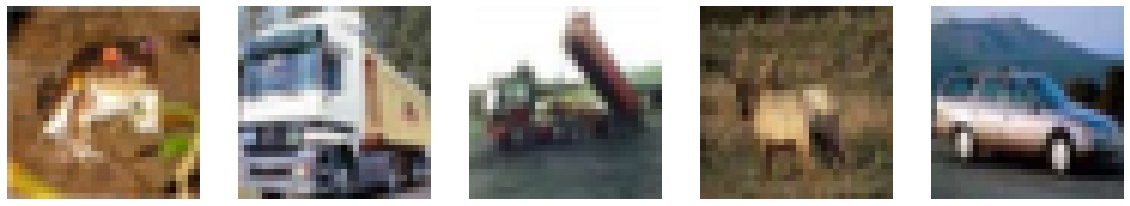

In [2]:
# Parameters
model = "Gabor"
SEED = 4+3+2022
DEVICE = "cuda"
RUN_INR = True
PLOT_IMAGE = True
PLOT_RESULTS = True

# Load in all model hyperparameters
if model == "Sine":
    cfg = OmegaConf.load('./configs/SINE_INR_cfg1.yaml')
elif model == "RFF":
    cfg = OmegaConf.load('./configs/RFF_INR_cfg.yaml')
elif model == "Gabor":
    cfg = OmegaConf.load('./configs/Gabor_INR_cfg1.yaml')
    cfg.batch_size = cfg.net.batch_size

# Final parameter
IMAGE_IDX = list(range(cfg.batch_size))

# if SEED:
#     torch.use_deterministic_algorithms(True)

# Get the training images
training_set = CIFAR10(transform=ToTensor(), root="data", download=True)
training_imgs = []
input_imgs = []
for image_id in IMAGE_IDX:
    training_img = training_set.__getitem__(image_id)[0].permute((1,2,0))
    training_imgs.append(training_img)
    input_imgs.append(training_img.to(DEVICE))
input_imgs = torch.stack(input_imgs, 0)

# # Used for calculating the PSNR
# MAX_I_CHANNEL = input_img.max().item()
# MAX_I = input_img.mean(2).max().item()

if PLOT_IMAGE:
    fig, ax = plt.subplots(1,len(training_imgs),figsize=(20,8))
    for i in range(len(training_imgs)):
        ax[i].imshow(training_imgs[i])
        ax[i].axis('off')
    plt.show()

C:\Users\Gebruiker\anaconda3\envs\master_thesis\lib\site-packages\torch\functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


Time Sine: 6.1936187744140625


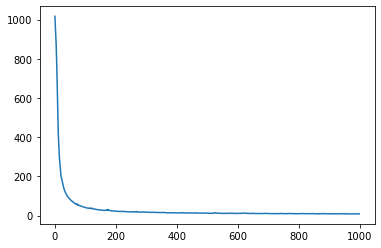

In [3]:
# We will be using the same coordinates for all models
train_coordinates = cifar_grid(32, cfg.batch_size).to(DEVICE)

# Setup the second model and its optimization scheme
if model == "Sine":
    INR = MLP(**cfg).to(DEVICE)
elif model == "RFF":
    INR = RFF(**cfg).to(DEVICE)
elif model == "Gabor":
    INR = Gabor(**cfg.net).to(DEVICE)

optimizer = torch.optim.Adam(INR.model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss(reduction='sum')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8)

# Run the second experiment
if RUN_INR:
    t_sine_start = time.time()
    epochs = [5]*200
    sine_losses = INR.fit(input_imgs, optimizer, criterion, scheduler, epochs, image_grid=train_coordinates)
    t_sine_end = time.time()
    print("Time Sine:", t_sine_end-t_sine_start)
    plt.plot(sine_losses)

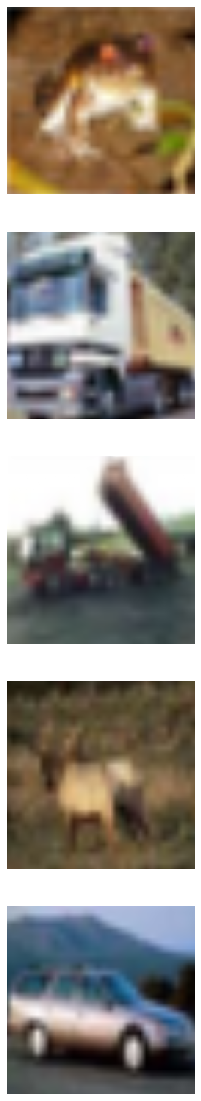

In [4]:
base = baseline(input_imgs.to("cpu"), factor=8)

fig, ax = plt.subplots(cfg.batch_size, figsize=(20,4*cfg.batch_size))

for i in range(cfg.batch_size):
    ax[i].imshow(base[i])
    ax[i].axis('off')
plt.show()

C:\Users\Gebruiker\anaconda3\envs\master_thesis\lib\site-packages\torch\_tensor.py:999: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1408.)
  return super(Tensor, self).rename(names)


Losses:
tensor([[0.0009, 0.0020, 0.0037, 0.0047],
        [0.0006, 0.0046, 0.0081, 0.0102],
        [0.0003, 0.0010, 0.0017, 0.0021],
        [0.0005, 0.0008, 0.0014, 0.0017],
        [0.0005, 0.0022, 0.0040, 0.0051]], names=('Image', 'Resolution'))


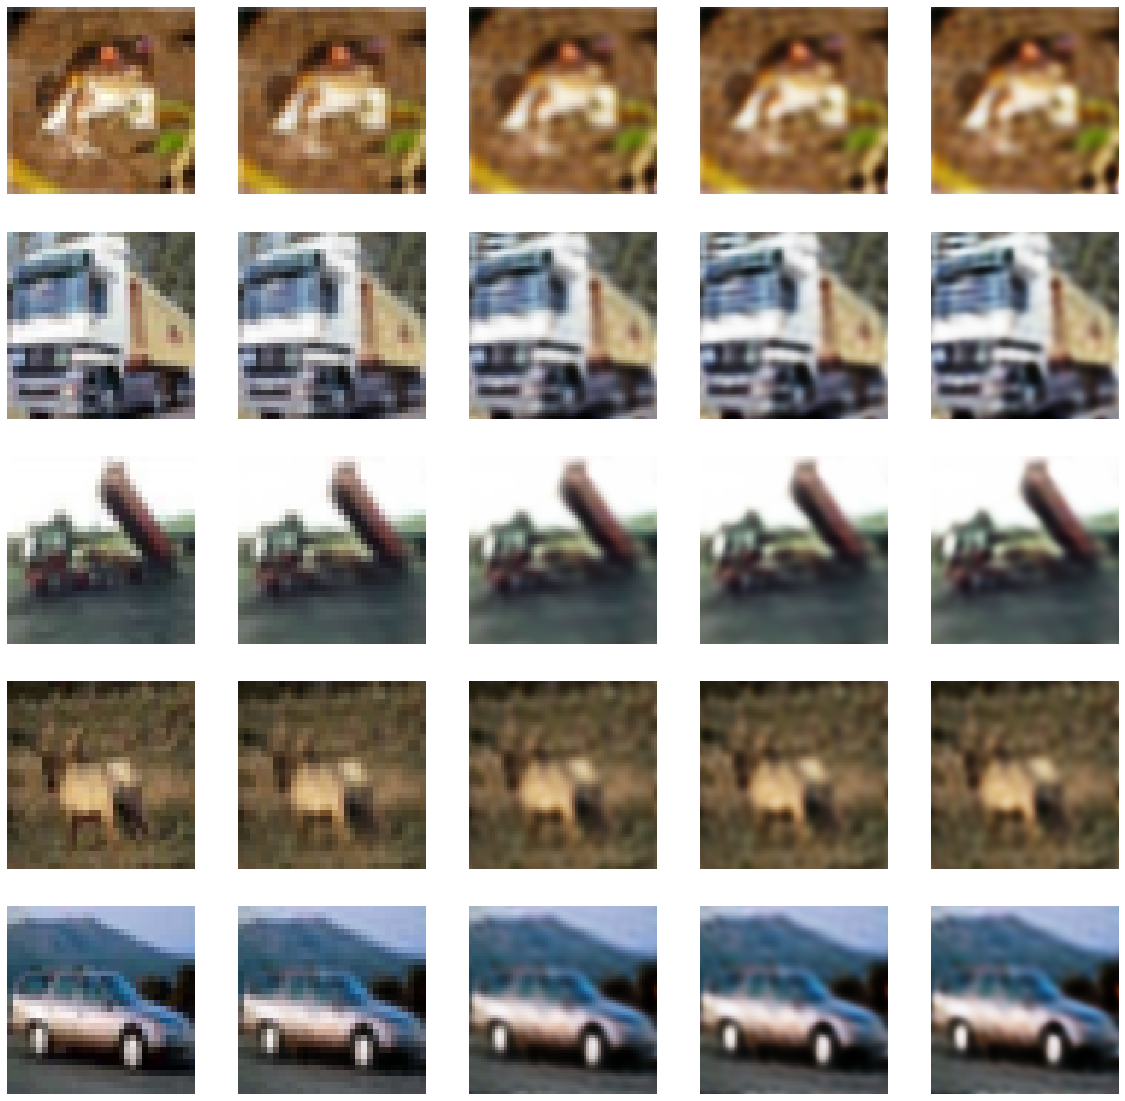

In [5]:
# Visualize the learned image representations

if PLOT_RESULTS:
    with torch.no_grad():
        coordinates1 = cifar_grid(32, cfg.batch_size).to(DEVICE)
        coordinates2 = cifar_grid(64, cfg.batch_size).to(DEVICE)
        coordinates3 = cifar_grid(128, cfg.batch_size).to(DEVICE)
        coordinates4 = cifar_grid(256, cfg.batch_size).to(DEVICE)

        out_sine = []
        out_sine.append(INR(coordinates1).to("cpu"))
        out_sine.append(INR(coordinates2).to("cpu"))
        out_sine.append(INR(coordinates3).to("cpu"))
        out_sine.append(INR(coordinates4).to("cpu"))

        plot_imgs = input_imgs.to("cpu")
        criterion = torch.nn.MSELoss(reduction='mean')
        
        losses = []
        for i in range(cfg.batch_size):
            losses.append([])
            for j in range(4):
                out = out_sine[j][i]
                gt = baseline(plot_imgs, factor=(2**j))[i]
                losses[i].append(criterion(out, gt).item())
        losses = torch.FloatTensor(losses)
        losses = losses.rename("Image", "Resolution")
        
        print("Losses:")
        print(losses)
    #     print("PSNR sine:", 20 * np.log10(MAX_I_CHANNEL) - 10 * np.log10(loss_sine))

        fig, ax = plt.subplots(cfg.batch_size,5,figsize=(20,4*cfg.batch_size))
        for i in range(cfg.batch_size):
            ax[i][0].imshow(training_imgs[i])
            ax[i][0].axis('off')
            for j in range(4):
                ax[i][j+1].imshow(out_sine[j][i])
                ax[i][j+1].axis('off')

In [6]:
omega0_range = []
omega0_initial_range = []

for i in torch.arange(1.5, 31.5, 1.5):
    omega0_range.append(round(i.item(), 5))
for i in torch.arange(0.005, 0.105, 0.005):
    omega0_initial_range.append(round(i.item(), 5))

print(omega0_range)
print(omega0_initial_range)

[1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.5, 12.0, 13.5, 15.0, 16.5, 18.0, 19.5, 21.0, 22.5, 24.0, 25.5, 27.0, 28.5, 30.0]
[0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1]


In [7]:
# coordinates1 = cifar_grid(32, cfg.batch_size).to(DEVICE)
# coordinates2 = cifar_grid(64, cfg.batch_size).to(DEVICE)
# coordinates3 = cifar_grid(128, cfg.batch_size).to(DEVICE)
# coordinates4 = cifar_grid(256, cfg.batch_size).to(DEVICE)

# criterion = torch.nn.MSELoss(reduction='mean')
# t_sine_start = time.time()
# for g in omega0_range:
#     cfg.omega0 = g
#     for h in omega0_initial_range:
#         cfg.omega0_initial = h
        
#         torch.manual_seed(SEED)
#         np.random.seed(SEED)
        
#         INR = MLP(**cfg).to(DEVICE)
#         optimizer = torch.optim.Adam(INR.model.parameters(), lr=0.01)
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8)
        
        
#         epochs = [5]*200
#         INR.fit(input_imgs, optimizer, criterion, scheduler, epochs, image_grid=train_coordinates)
        
#         with torch.no_grad():
#             out_sine = []
#             out_sine.append(INR(coordinates1).to("cpu"))
#             out_sine.append(INR(coordinates2).to("cpu"))
#             out_sine.append(INR(coordinates3).to("cpu"))
#             out_sine.append(INR(coordinates4).to("cpu"))

#             losses = []
#             for i in range(cfg.batch_size):
#                 losses.append([])
#                 for j in range(4):
#                     out = out_sine[j][i]
#                     gt = baseline(plot_imgs, factor=(2**j))[i]
#                     losses[i].append(criterion(out, gt).item())
#             losses = torch.FloatTensor(losses)
#             torch.save(losses, f"param_sweep/losses/{g}, {h}.pt")

#             fig, ax = plt.subplots(cfg.batch_size,5,figsize=(20,4*cfg.batch_size))
#             for i in range(cfg.batch_size):
#                 ax[i][0].imshow(training_imgs[i])
#                 ax[i][0].axis('off')
#                 for j in range(4):
#                     ax[i][j+1].imshow(out_sine[j][i])
#                     ax[i][j+1].axis('off')
#             plt.savefig(f"param_sweep/plots/{g}, {h}.png")
# t_sine_end = time.time()
# print("Time Sine:", t_sine_end-t_sine_start)

In [8]:
import imageio

losses = {}
for g in omega0_range:
    for h in omega0_initial_range:
        losses[f"{g},{h}"] = torch.load(f"./param_sweep/losses/{g}, {h}.pt").mean(0)[0].item()

loss = torch.load(f"./param_sweep/losses/13.5, 0.03.pt")
print(loss)
# with imageio.get_writer('param_sweep1.gif', mode='I') as writer:
#     for g in omega0_range:
#         for h in omega0_initial_range:
            
#             image = imageio.imread(f"./param_sweep/plots/{g}, {h}.png")
#             writer.append_data(image)

# with imageio.get_writer('param_sweep2.gif', mode='I') as writer:
#     for h in omega0_initial_range:
#         for g in omega0_range:

#             image = imageio.imread(f"./param_sweep/plots/{g}, {h}.png")
#             writer.append_data(image)

tensor([[0.0006, 0.0022, 0.0040, 0.0050],
        [0.0011, 0.0052, 0.0087, 0.0108],
        [0.0004, 0.0011, 0.0019, 0.0023],
        [0.0004, 0.0009, 0.0015, 0.0018],
        [0.0004, 0.0023, 0.0041, 0.0052]])


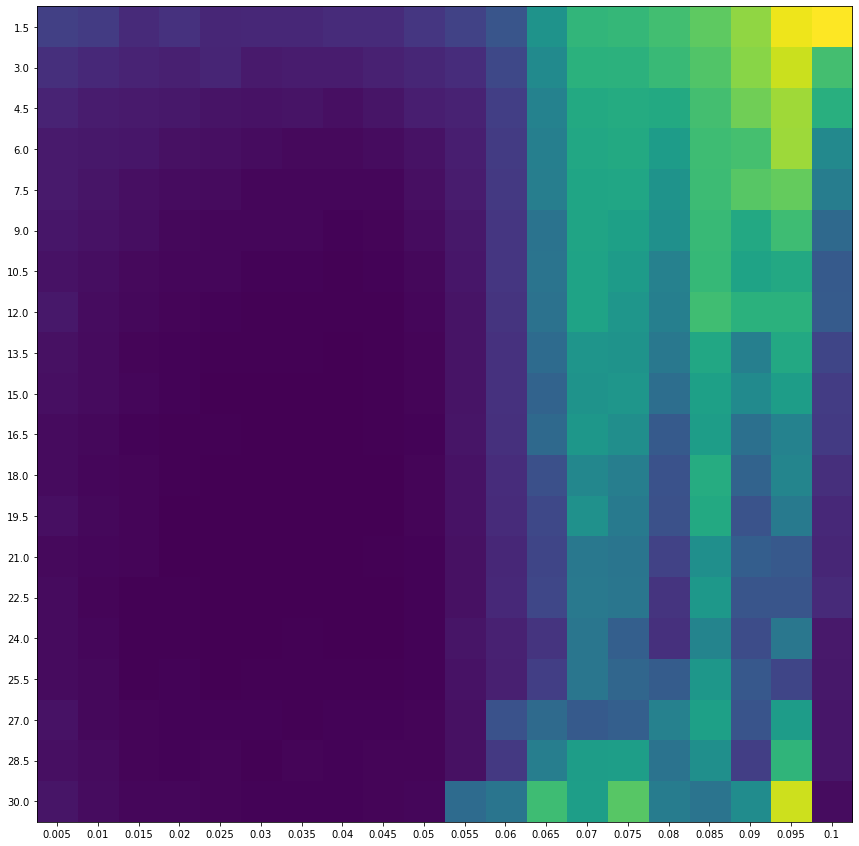

In [9]:
loss_tensor = []
for g in omega0_range:
        loss_tensor.append([])
        for h in omega0_initial_range:
            loss_tensor[-1].append(losses[f"{g},{h}"])
loss_tensor = torch.FloatTensor(loss_tensor)

plt.figure(figsize=(15, 15))
plt.imshow(loss_tensor)
plt.xticks(ticks=range(20), labels=omega0_initial_range)
plt.yticks(ticks=range(20), labels=omega0_range)
plt.show()